# Determine Data Mapping Accuracy

#### Updated: Feb 1, 2023 by Ashley Ferreira

The purpose of this notebook is to determine the accuracy with which earlier notebooks are able to map the true values from the ionogram images to numpy arrays. This is done by following the steps:
1. Randomly load in a set of ionogram images
2. TBC
3. TBC
4. Use variance to estimate data mapping accuracy for the entire set of images, as well as potentially flag if there are certain directories or cases which have significantly better or significantly worse accuracies.

For now, it repeats much of the code found in notebook 01 and 08 just to get started.

#### Import libraries and set global variables

In [1]:
import pandas as pd
import numpy as np
import os
import random
from random import randrange
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [2]:
resultDir = 'L:/DATA/Alouette_I/BATCH_I_Run1/05_result/'
imageDir = 'L:/DATA/Alouette_I/BATCH_I_Run1/04_processed/'
logDir = 'L:/DATA/Alouette_I/BATCH_I_Run1/06_log/'

In [18]:
sample_size = 15

#### Initialize functions
Code is an adapted copy of inspect_ionograms() from notebook 08

In [28]:
def inspect_ionogram_data(roll, subdirectory, sample_list, imageDir, resultDir):
    
    mapped_coords_list = os.listdir(resultDir + 'mapped_coords/' + roll + '/' + subdirectory + '/')
    df_result = pd.read_csv(resultDir + roll + '/result-' + roll + '_' + subdirectory + '.csv')
    
    min_depth_lst = []
    max_freq_lst = []
    binary_accuracy_lst = []
    not_counted_images = 0
    for image_fn in sample_list:
        print(image_fn)
        image_fn_ = image_fn.replace('.png', '')

        f, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1,1.2],}, figsize=(20,5))

        for mapped_coord_fn in mapped_coords_list:
            if '_' + image_fn_ + '.npy' in mapped_coord_fn:
                arr_load = np.load(resultDir + 'mapped_coords/' + roll + '/' + subdirectory + '/' + mapped_coord_fn)

                df_plot = pd.DataFrame({
                'f': arr_load[:, 0],
                'depth': arr_load[:, 1]
                })
                df_plot['depth_plot'] = -1*df_plot['depth']

                min_depth = min(df_plot['depth_plot'])
                max_depth = max(df_plot['depth_plot'])
                min_freq = min(df_plot['f'])
                max_freq = max(df_plot['f'])

                min_depth_loc = np.argmin(df_plot['depth_plot'])
                freq_at_min_depth = df_plot['f'][min_depth_loc]

                axs[0].scatter(df_plot['f'], df_plot['depth_plot'], 1, color='black')
                axs[0].set(xlabel='frequency (MHz)', ylabel='depth (km)')
                axs[0].hlines(min_depth, min_freq, max_freq, linestyle='--', color='purple', label='min depth')
                axs[0].vlines(freq_at_min_depth, min_depth, max_depth, linestyle='--', color='orange', label='frequency at min depth')
                axs[0].legend(loc='best')
                axs[0].grid()
                axs[0].set_ylim(-1500, 0)
                axs[0].set_xlim(0, 12)

        img = mpimg.imread(imageDir + roll + '/' + subdirectory + '/' + image_fn)
        axs[1].imshow(img, cmap='gray')
        axs[1].set(xticks=[], yticks=[])
        
        #Results
        df_result_img = df_result.loc[df_result['filename'] == image_fn]
        
        plt.show()
        print(df_result_img['processed_image_class'].iloc[0])
        print(df_result_img['Station Name'].iloc[0])
        if df_result_img['processed_image_class'].iloc[0] == 'loss':
            print(df_result_img['func_name'].iloc[0])
        elif df_result_img['processed_image_class'].iloc[0] == 'outlier':
            print(df_result_img['func_name'].iloc[0])

        print('minimum depth found at (', freq_at_min_depth, 'MHz,', min_depth, 'km )')
        print("Enter 1 for correct minimum depth, 0 for incorrect:")
        value = int(input())
        print("you entered:", value)
        if value == 0 or value == 1:
            binary_accuracy_lst.append(value)
        else:
            not_counted_images += 1
        print('\n\n')

        min_depth_lst.append(min_depth)
        max_freq_lst.append(max_freq)

    # evaluate binary accuracy
    binary_accuracy = sum(binary_accuracy_lst)/len(binary_accuracy_lst)
    print('binary accuracy:', binary_accuracy*100, '%')
    print(not_counted_images, 'were not counted due to ambiguous data')

    return min_depth_lst, max_freq_lst

#### Read in log

In [20]:
df_process_log = pd.read_csv(logDir + 'process_log.csv')
print('number of processed ionograms (i think):', len(df_process_log))
subdir_ids_list = df_process_log['subdir_id'].unique()
df_process_log.head()

number of processed ionograms (i think): 3138


,Roll,Subdirectory,Images_processed,Images_dot,Images_num,Images_loss,Images_outlier,Process_time,Process_timestamp,User,subdir_id
0,R014207978F,319,239,206,5,11,17,259.625649,2022-12-15 23:28:15.951151,Rav,R014207978F_319
1,R014207966,1185-1B,386,0,383,0,3,1415.449691,2022-12-15 23:51:57.608703,Rav,R014207966_1185-1B
2,R014207975,1108-B,363,0,347,4,12,367.330205,2022-12-15 23:58:19.342118,Rav,R014207975_1108-B
3,R014207957,2631-1A,333,0,320,4,9,607.819416,2022-12-16 00:08:43.220755,Rav,R014207957_2631-1A
4,R014207966,1150-B,369,0,362,1,6,775.810147,2022-12-16 00:21:52.993215,Rav,R014207966_1150-B


#### Randomly select 1 subdirectory ID

In [22]:
subdir_id = subdir_ids_list[randrange(len(subdir_ids_list))]
parts = subdir_id.split('_')
roll = parts[0]
subdirectory = parts[1]
print('roll:', roll)
print('subdir:', subdirectory)

roll: R014207967
subdir: 1412-8B


#### Randomly sample ionogram images
From the subdirectory selected in the previous code block, randomly sample a number of images specified by the sample_size variable.

In [23]:
images_list = os.listdir(imageDir + roll + '/' + subdirectory + '/')
sample_list = random.sample(images_list, sample_size)
print('selected ionogram images:', sample_list)

selected ionogram images: ['174.png', '69.png', '163.png', '271.png', '58.png', '37.png', '288.png', '51.png', '290.png', '85.png', '220.png', '119.png', '129.png', '186.png', '176.png']


#### Display sampled images

The ionograms contain three key peices of information:
1. **Metadata**: listed outside of the main plot using printed numbers and at times just dots. We are not concerned with validating the metadata in this notebook as it is done elsewhere. 
2. **Depth**: the depth is displayed inverse-linearly on the y-axis, with each horizontal line signifying 100 km distance increments. There is a consistely dark line at the top of the plot which represents 0 km and therefore immediate reflection. There is often a hockey stick shape with tapering off near 1000 km which signifies the approximate location of the Earth's surface. 
3. **Frequency**: the frequency is not displayed in a consistent linear scale like the depth but the vertical lines are at known MHz values.

From what I have seen so far all ionograms will follow the same identical x and y axis. 

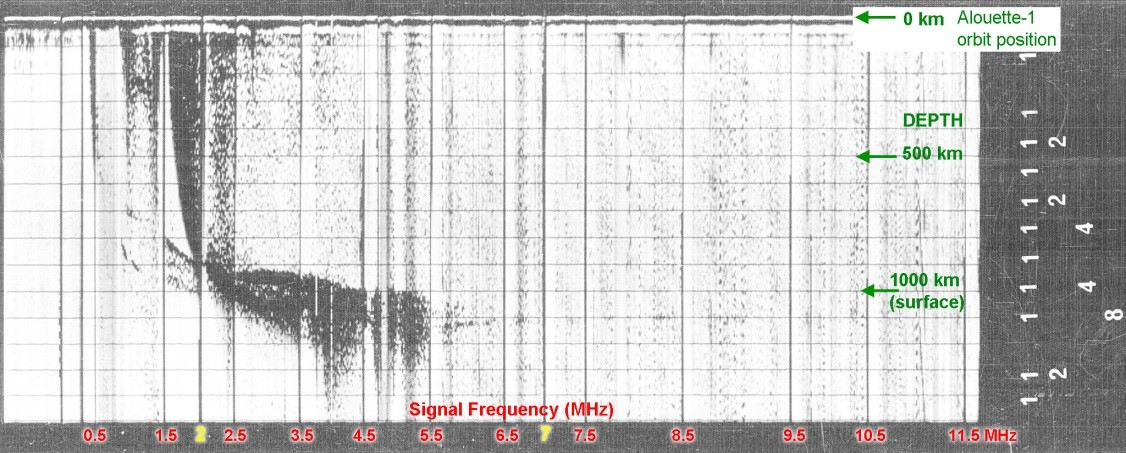

In [29]:
# don't rerun this cell if you do not have image file
from IPython.display import Image
Image(filename=os.getcwd()+'\\ionogram_markers.jpg') 

The labelled figure above is taken from the Data Specifications Alouette-I Ionograms document.

For a temporary first estimate of the accuracy is to simply ask for manual input to see if the printed minimum depth is resonably close to the real one when referencing the ionogram image on the right hand side of the figure.

User enters:
- 0 for incorrect minimum depth location
- 1 for resonably correct minimum depth (+/- 50 km)
- 2 for no clear hockey stick structure
- 3 for null/invalid data that that makes the user uncertain about true minimum

The later two will not be included in the rough accuracy calculation.

174.png


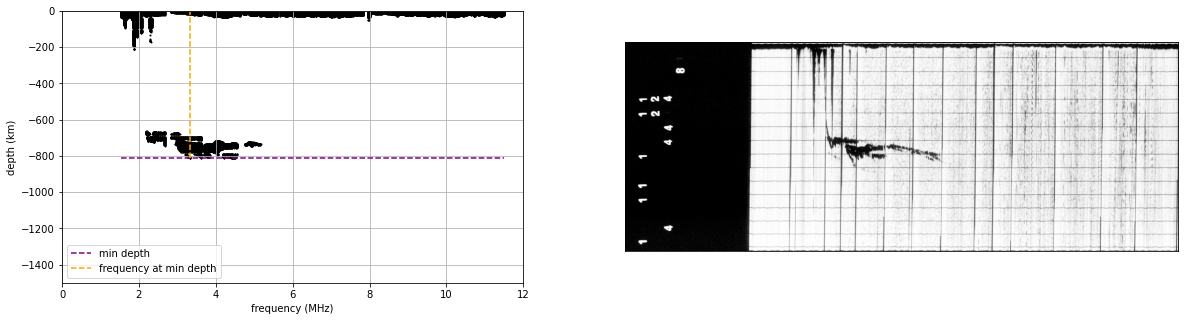

num
Santiago, Chile 
minimum depth found at ( 3.3363636363636364 MHz, -811.1111111111111 km )
Enter 1 for correct minimum depth, 0 for incorrect:



69.png


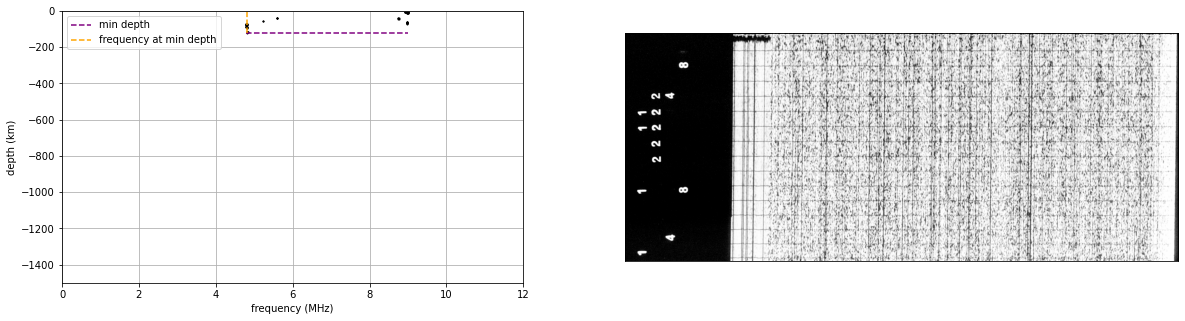

num
Santiago, Chile 
minimum depth found at ( 4.824074074074074 MHz, -120.37037037037037 km )
Enter 1 for correct minimum depth, 0 for incorrect:



163.png


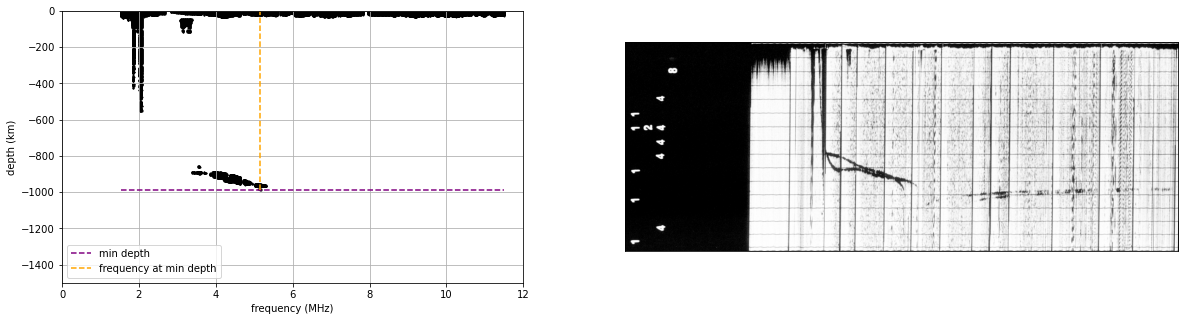

num
Santiago, Chile 
minimum depth found at ( 5.138888888888889 MHz, -985.1851851851852 km )
Enter 1 for correct minimum depth, 0 for incorrect:



271.png


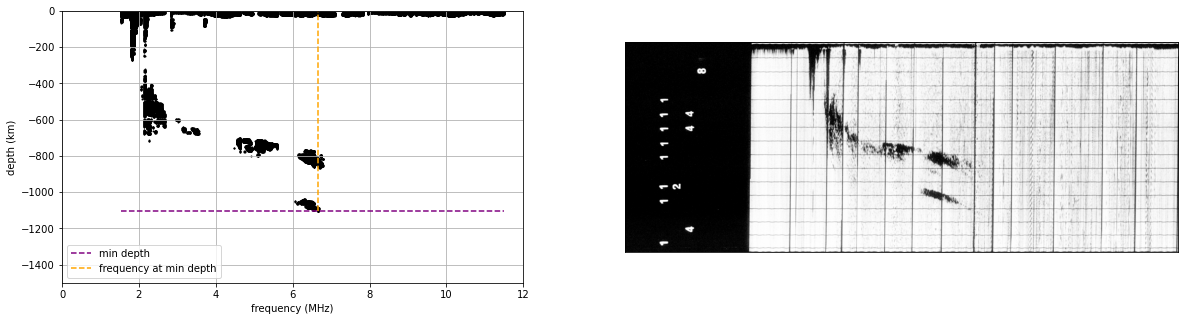

num
Santiago, Chile 
minimum depth found at ( 6.662698412698413 MHz, -1105.5555555555557 km )
Enter 1 for correct minimum depth, 0 for incorrect:



58.png


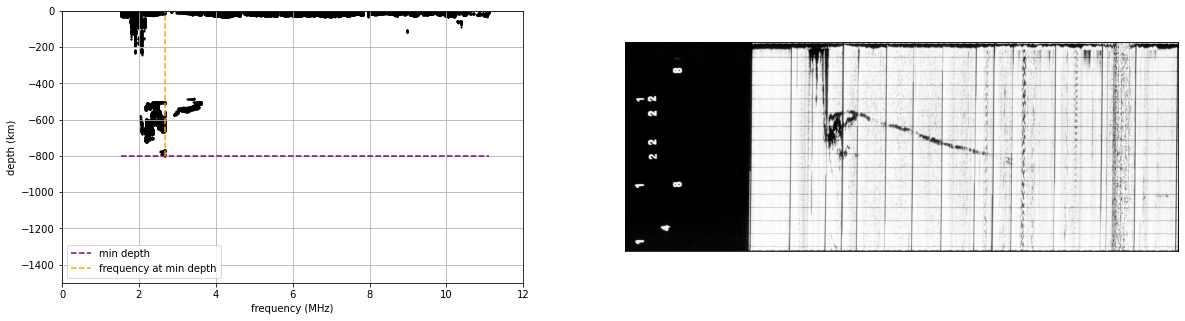

num
Santiago, Chile 
minimum depth found at ( 2.6818181818181817 MHz, -800.0 km )
Enter 1 for correct minimum depth, 0 for incorrect:



37.png


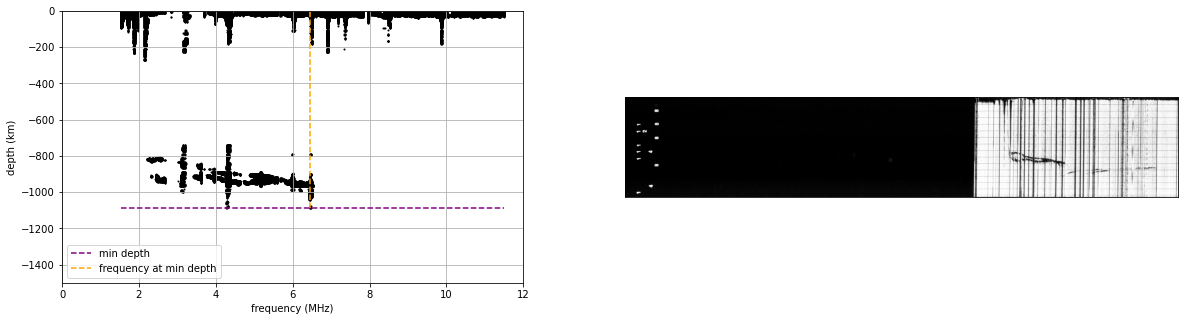

num
Santiago, Chile 
minimum depth found at ( 6.462616822429906 MHz, -1087.037037037037 km )
Enter 1 for correct minimum depth, 0 for incorrect:



288.png


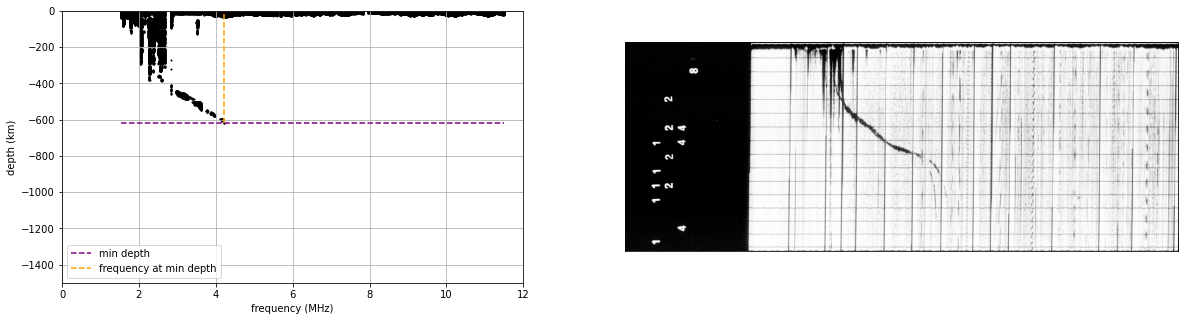

num
Santiago, Chile 
minimum depth found at ( 4.2075471698113205 MHz, -618.5185185185185 km )
Enter 1 for correct minimum depth, 0 for incorrect:



51.png


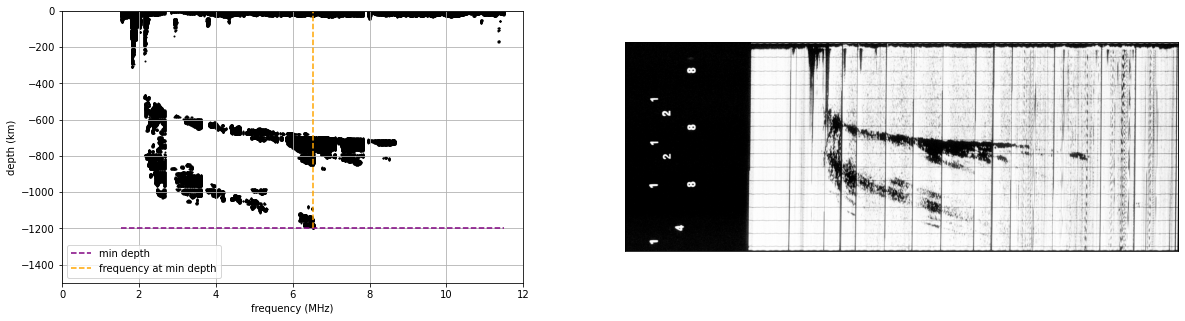

num
Santiago, Chile 
minimum depth found at ( 6.531746031746032 MHz, -1200.0 km )
Enter 1 for correct minimum depth, 0 for incorrect:



290.png


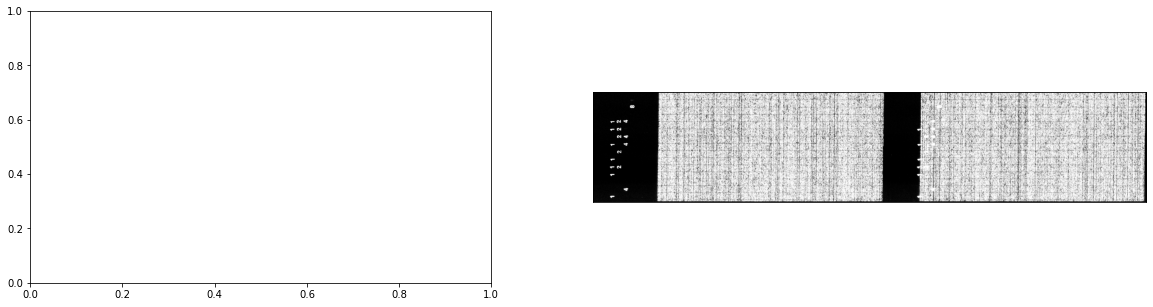

outlier
nan
image_segmentation.segment_images_in_subdir.segment_images: iono size outlier
minimum depth found at ( 6.531746031746032 MHz, -1200.0 km )
Enter 1 for correct minimum depth, 0 for incorrect:



85.png


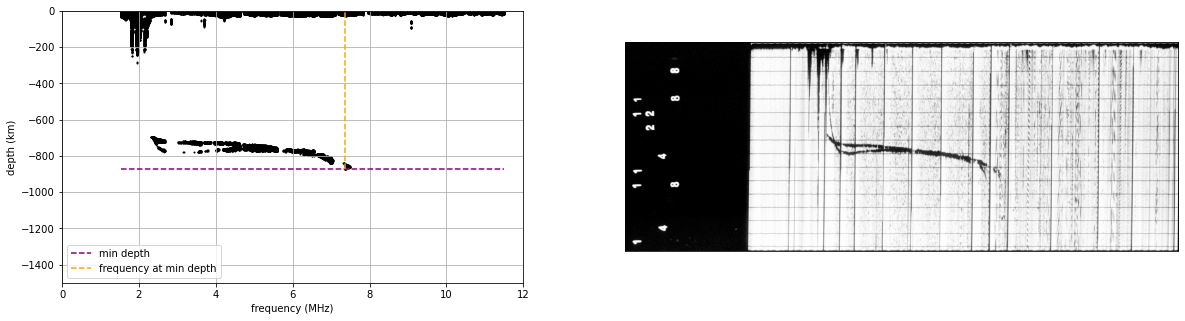

num
Santiago, Chile 
minimum depth found at ( 7.352459016393443 MHz, -872.2222222222222 km )
Enter 1 for correct minimum depth, 0 for incorrect:



220.png


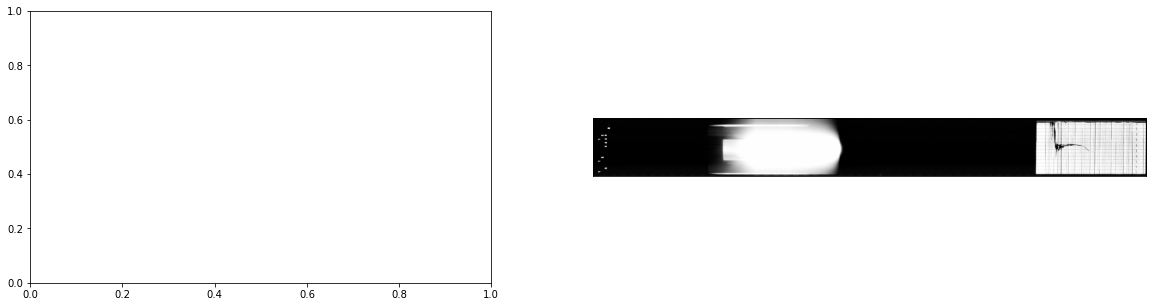

outlier
nan
image_segmentation.segment_images_in_subdir.segment_images: iono size outlier
minimum depth found at ( 7.352459016393443 MHz, -872.2222222222222 km )
Enter 1 for correct minimum depth, 0 for incorrect:



119.png


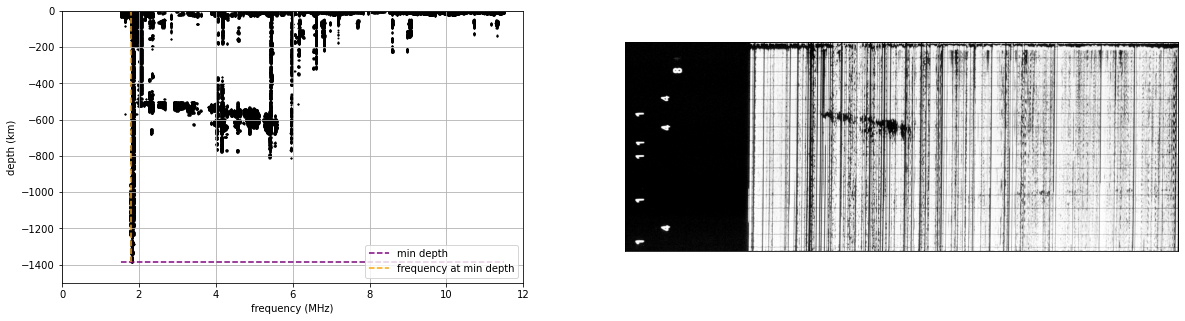

num
Santiago, Chile 
minimum depth found at ( 1.8064516129032258 MHz, -1383.3333333333333 km )
Enter 1 for correct minimum depth, 0 for incorrect:



129.png


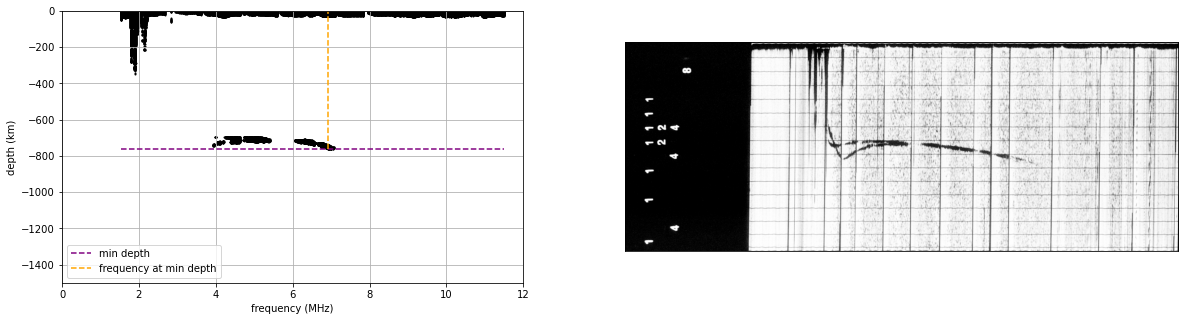

num
Santiago, Chile 
minimum depth found at ( 6.928571428571429 MHz, -761.1111111111111 km )
Enter 1 for correct minimum depth, 0 for incorrect:



186.png


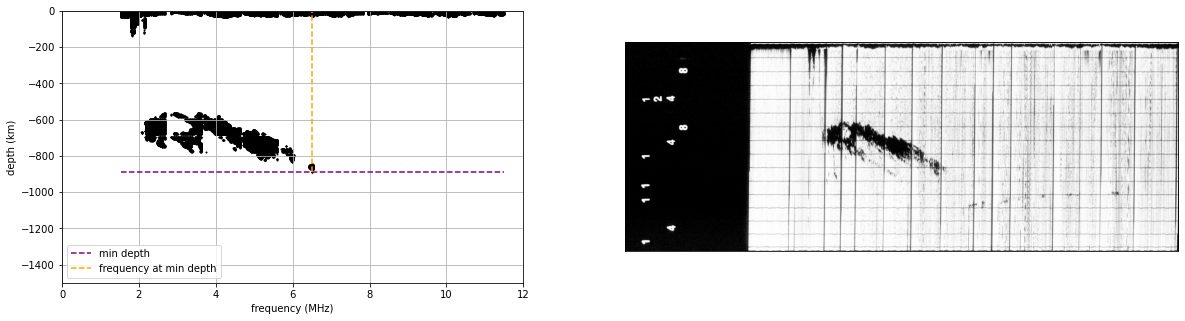

num
Santiago, Chile 
minimum depth found at ( 6.5 MHz, -887.0370370370371 km )
Enter 1 for correct minimum depth, 0 for incorrect:



176.png


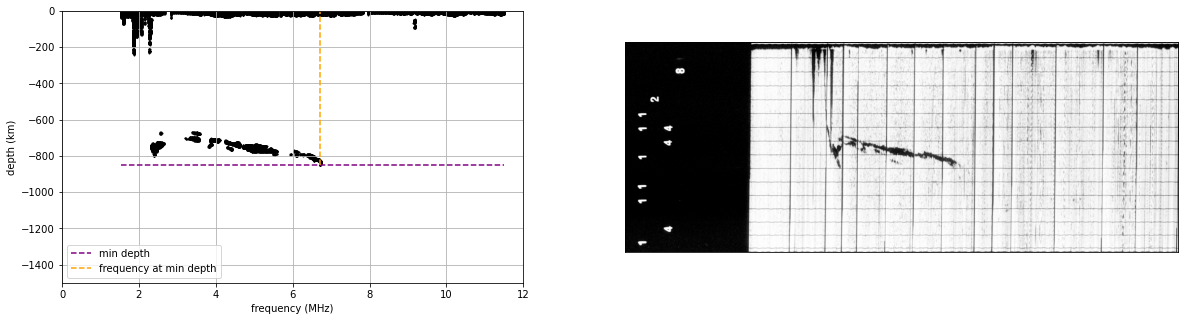

num
Santiago, Chile 
minimum depth found at ( 6.7063492063492065 MHz, -850.0 km )
Enter 1 for correct minimum depth, 0 for incorrect:



binary accuracy: 81.81818181818183 %
4 were not counted due to ambiguous data


In [30]:
min_depths, max_freqs = inspect_ionogram_data(roll=roll, subdirectory=subdirectory, sample_list=sample_list, imageDir=imageDir, resultDir=resultDir)

#### Read in results summary file
This file gives the high-level stats for all the processed ionograms. A warning that this is a very large CSV file an the code block below will likely take a few minutes to complete.

keep this as extra thing to compare to later

In [3]:
# only loading in a subsection of the full results (not same 5 as above yet)
df_results_sum = pd.read_csv(resultDir + 'result_total_mdrp.csv', nrows=5)
df_results_sum.head()

,fmin_Run1,max_depth_Run1,satellite_number_Run1,year_Run1,day_Run1,hour_Run1,minute_Run1,second_Run1,station_number_Run1,Station Name_Run1,...,y_centroids_Run1_md,is_dot_Run1_md,dict_metadata_Run1_md,details_Run1_md,Roll_Run1_md,Subdirectory_Run1_md,filename_Run1_md,rotated_metadata_Run1,station_code_Run1,station_code_Run1_md
0,1.5,387.500000,1.0,1961.0,3.0,2.0,2.0,3.0,3.0,"Ottawa, Canada",...,NaN,NaN,NaN,NaN,R014207815,3488-15A,10.png,NaN,NaN,NaN
1,1.5,556.250000,1.0,1961.0,2.0,2.0,2.0,3.0,3.0,"Ottawa, Canada",...,NaN,NaN,NaN,NaN,R014207815,3488-15A,101.png,NaN,NaN,NaN
2,1.5,654.166667,0.0,1960.0,2.0,2.0,3.0,2.0,3.0,"Ottawa, Canada",...,NaN,NaN,NaN,NaN,R014207815,3488-15A,102.png,NaN,NaN,NaN
3,1.5,504.166667,0.0,1960.0,2.0,2.0,3.0,2.0,3.0,"Ottawa, Canada",...,NaN,NaN,NaN,NaN,R014207815,3488-15A,106.png,NaN,NaN,NaN
4,1.5,504.166667,0.0,1961.0,2.0,2.0,2.0,3.0,3.0,"Ottawa, Canada",...,NaN,NaN,NaN,NaN,R014207815,3488-15A,107.png,NaN,NaN,NaN


In [5]:
# exploring the column names
# (75 is too many to see in table preview)
for col in df_results_sum.columns:
    print(col)

fmin_Run1
max_depth_Run1
satellite_number_Run1
year_Run1
day_Run1
hour_Run1
minute_Run1
second_Run1
station_number_Run1
Station Name_Run1
3 - Letter Code_Run1
LAT._Run1
LONG. _Run1
processed_image_class_Run1
func_name_Run1
limits_Run1
height_Run1
width_Run1
metadata_type_Run1
meta_height_Run1
meta_width_Run1
x_centroids_Run1
y_centroids_Run1
is_dot_Run1
dict_metadata_Run1
raw_coord_Run1
window_coord_Run1
mapping_Hz_Run1
mapping_km_Run1
details_Run1
Roll
Subdirectory
filename
satellite_number_Run1_md
year_Run1_md
day_1_Run1_md
day_2_Run1_md
day_3_Run1_md
hour_1_Run1_md
hour_2_Run1_md
minute_1_Run1_md
minute_2_Run1_md
second_1_Run1_md
second_2_Run1_md
station_number_1_Run1_md
station_number_2_Run1_md
day_Run1_md
hour_Run1_md
minute_Run1_md
second_Run1_md
station_number_Run1_md
Station Name_Run1_md
3 - Letter Code_Run1_md
LAT._Run1_md
LONG. _Run1_md
processed_image_class_Run1_md
func_name_Run1_md
limits_Run1_md
height_Run1_md
width_Run1_md
metadata_type_Run1_md
meta_height_Run1_md
meta_wi

So we will look at the frequency and depth minimum, using fmin_Run1 and max_depth_Run1 respectively.

In [16]:
# checking if file names are unique